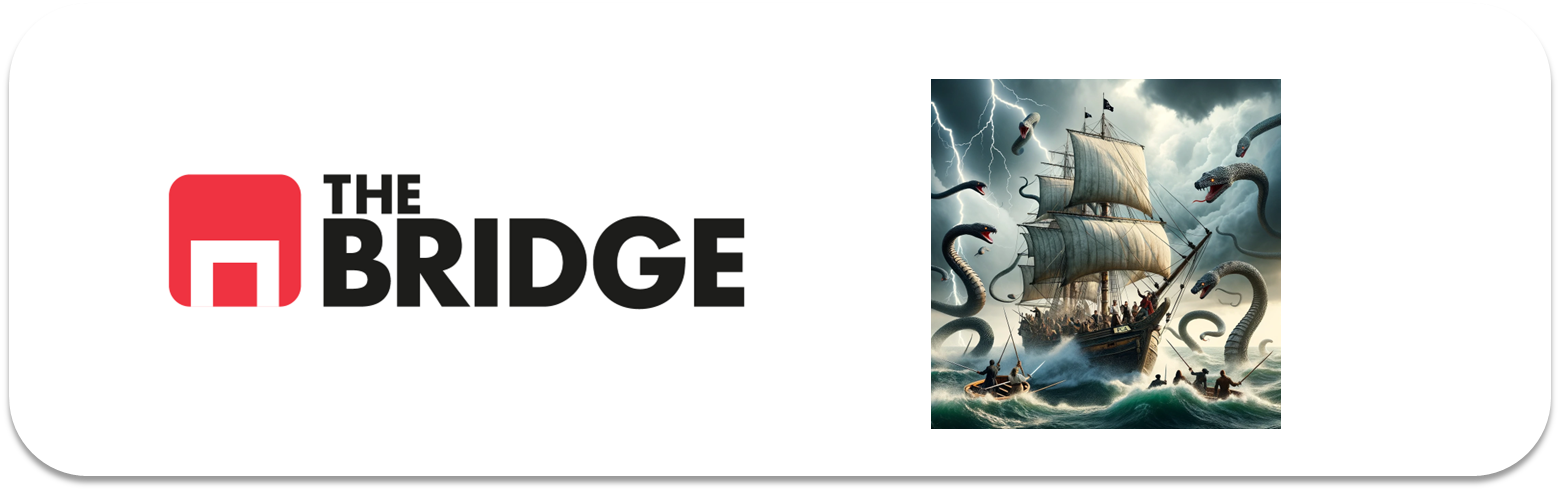

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

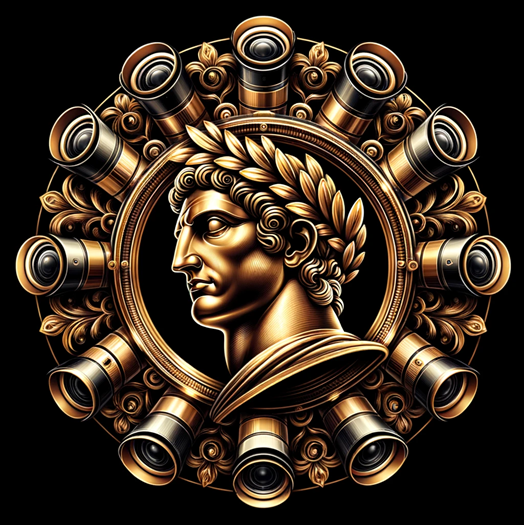

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import Toolbox_ML as tlb
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn  as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from sklearn.datasets import fetch_olivetti_faces

from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [2]:
olivetti_faces = fetch_olivetti_faces()
print(olivetti_faces.DESCR)
df = pd.DataFrame(data=olivetti_faces.data)
df["Persona"] = olivetti_faces["target"]
df.head()

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Persona
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [3]:
df = df.sample(frac=1)
df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Persona
258,0.619835,0.681818,0.698347,0.710744,0.710744,0.714876,0.714876,0.731405,0.743802,0.756198,...,0.169421,0.148760,0.190083,0.235537,0.293388,0.326446,0.338843,0.355372,0.318182,25
321,0.136364,0.128099,0.123967,0.119835,0.119835,0.107438,0.128099,0.140496,0.119835,0.140496,...,0.471074,0.619835,0.652893,0.380165,0.396694,0.578512,0.669421,0.636364,0.561983,32
261,0.388430,0.462810,0.553719,0.702479,0.760331,0.768595,0.768595,0.776860,0.793388,0.797521,...,0.078512,0.086777,0.082645,0.095041,0.140496,0.144628,0.157025,0.152893,0.181818,26
160,0.433884,0.466942,0.524793,0.533058,0.553719,0.553719,0.557851,0.578512,0.619835,0.640496,...,0.214876,0.190083,0.181818,0.177686,0.169421,0.177686,0.173554,0.169421,0.169421,16
197,0.252066,0.330579,0.396694,0.442149,0.512397,0.545455,0.545455,0.607438,0.619835,0.661157,...,0.322314,0.409091,0.896694,0.822314,0.752066,0.628099,0.586777,0.590909,0.603306,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.768595,0.735537,0.764463,0.793388,0.805785,0.789256,0.789256,0.747934,0.789256,0.785124,...,0.194215,0.392562,0.334711,0.322314,0.342975,0.371901,0.301653,0.314050,0.371901,27
69,0.301653,0.272727,0.380165,0.483471,0.690083,0.698347,0.719008,0.747934,0.764463,0.776860,...,0.491736,0.570248,0.681818,0.636364,0.669421,0.305785,0.264463,0.314050,0.305785,6
344,0.326446,0.322314,0.314050,0.305785,0.256198,0.181818,0.425620,0.524793,0.545455,0.586777,...,0.400826,0.421488,0.458678,0.487603,0.520661,0.533058,0.524793,0.545455,0.541322,34
209,0.198347,0.235537,0.351240,0.409091,0.421488,0.429752,0.500000,0.528926,0.524793,0.553719,...,0.508264,0.524793,0.504132,0.483471,0.471074,0.285124,0.061983,0.128099,0.090909,20


In [4]:
target = "Persona"
train_set, test_set = train_test_split(df, stratify=df[target], test_size=0.2, random_state=42)

In [5]:
tlb.describe_df(df)

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Persona
Tipos,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
% Faltante,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores Únicos,151,158,149,157,147,139,131,122,115,110,...,152,156,150,155,148,157,149,144,138,40
% Cardinalidad,37.75,39.5,37.25,39.25,36.75,34.75,32.75,30.5,28.75,27.5,...,38.0,39.0,37.5,38.75,37.0,39.25,37.25,36.0,34.5,10.0


Las variabes son los pixeles de las imagenes. Tiene valores entre 0 y 1 que indican la intensidad del pixel en balnco y negro. No hay nulos.

No es necesario hacer EDA

In [6]:
X_train = train_set.drop(columns=target)
y_train = train_set[target]
X_test = test_set.drop(columns=target)
y_test = test_set[target]

In [7]:
model_names = ["KNN", "Reg. Logistica", "Random Forest"]

knn_clf = KNeighborsClassifier(n_neighbors=3)
lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth=5, random_state= 42)

model_set = [knn_clf, lr_clf, rf_clf]

In [8]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(f"Para {nombre}:", end = " ")
    metrica = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    
    print(np.mean(metrica))
    metricas_cv[nombre] = metrica
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]
print(f"And the winner is: {ganador} con una metrica de {np.mean(metricas_cv[ganador])}")

Para KNN: 0.8150000000000001
Para Reg. Logistica: 0.9550000000000001
Para Random Forest: 0.6599999999999999
And the winner is: Reg. Logistica con una metrica de 0.9550000000000001


In [9]:
mod_base = LogisticRegression(max_iter = 10000)
mod_base.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [10]:
y_pred_mod_base = mod_base.predict(X_test)
print(classification_report(y_test, y_pred_mod_base))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

In [11]:
mod_base_2 = KNeighborsClassifier(n_neighbors=3)
mod_base_2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [12]:
y_pred_mod_base_2 = mod_base.predict(X_test)
print(classification_report(y_test, y_pred_mod_base_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [13]:
pca_X_train = PCA()
pca_X_train.fit(X_train)

PCA()

In [14]:
pca_X_train.n_components_

320

In [15]:
pca_X_train.components_.shape

(320, 4096)

In [16]:
pca_X_train.components_

array([[ 4.4656764e-03,  7.1983575e-03,  9.5732883e-03, ...,
        -7.8148476e-04, -4.2476836e-03, -3.5558927e-03],
       [-2.8257795e-02, -3.3004101e-02, -3.7830584e-02, ...,
         2.9615551e-02,  2.7595865e-02,  2.6237158e-02],
       [ 7.8313891e-04, -6.5123849e-04, -2.7667137e-04, ...,
        -1.8233584e-02, -1.6264904e-02, -1.3600818e-02],
       ...,
       [-2.5099797e-02, -1.5319327e-02,  2.8475188e-03, ...,
        -9.2467509e-04, -2.7312594e-02,  1.1496155e-02],
       [ 3.9693031e-02,  4.0990543e-02, -5.4406524e-03, ...,
         5.1291804e-03, -3.6054424e-03, -2.4987156e-02],
       [-1.7480867e-03, -9.2349772e-05,  3.2858602e-03, ...,
         3.9881049e-03, -1.1954233e-02, -4.0051215e-03]], dtype=float32)

In [17]:
pca_X_train.explained_variance_ratio_.cumsum()

array([0.23297456, 0.37005043, 0.45151645, 0.50203246, 0.53920084,
       0.5711683 , 0.5957882 , 0.6169276 , 0.63757914, 0.6555702 ,
       0.6720471 , 0.6864689 , 0.6988545 , 0.7106906 , 0.72172105,
       0.7314978 , 0.7406127 , 0.7486042 , 0.75648177, 0.76410055,
       0.7713656 , 0.777989  , 0.78396004, 0.7897702 , 0.79539955,
       0.8008956 , 0.80621254, 0.81117785, 0.8159414 , 0.8204662 ,
       0.8247006 , 0.82864076, 0.8323433 , 0.83583057, 0.83924556,
       0.84250206, 0.84569365, 0.8487117 , 0.8517001 , 0.85454416,
       0.85730934, 0.8599354 , 0.8624733 , 0.8649523 , 0.8673551 ,
       0.8697341 , 0.8720206 , 0.87427896, 0.8764852 , 0.8785813 ,
       0.88059473, 0.88255686, 0.88447285, 0.88633066, 0.88815737,
       0.889954  , 0.89170533, 0.8934377 , 0.8951331 , 0.896815  ,
       0.8984317 , 0.9000163 , 0.90155333, 0.9030691 , 0.90453684,
       0.9059753 , 0.9074039 , 0.9088098 , 0.9102002 , 0.91154355,
       0.91287744, 0.9141702 , 0.91543084, 0.91665745, 0.91787

In [18]:
num_col_original = len(X_train.columns)
num_col_original

4096

In [19]:
num_pca_min = .002 * num_col_original
num_pca_max = .025 * num_col_original
print("Numero de PCAs para una comprension al 0.2%", num_pca_min)
print("Numero de PCAs para una comprension al 2.5%", num_pca_max)

Numero de PCAs para una comprension al 0.2% 8.192
Numero de PCAs para una comprension al 2.5% 102.4


In [20]:
rango_10 = [int(valor) for valor in np.linspace(int(num_pca_min), int(num_pca_max), 10)]
print("Rango de PCAs que voy a probar", rango_10 )

Rango de PCAs que voy a probar [8, 18, 28, 39, 49, 60, 70, 81, 91, 102]


In [21]:
X_train_transf = pca_X_train.transform(X_train)
X_test_transf = pca_X_train.transform(X_test)

In [22]:
X_train_transf.shape

(320, 320)

In [23]:
X_test_transf.shape

(80, 320)

In [24]:
base_cv = np.mean(metricas_cv[ganador])
base_cv

0.9550000000000001

In [25]:
base_test = recall_score(y_test, y_pred_mod_base, average = "macro")
base_test

0.9875

In [26]:

model_pca = LogisticRegression(max_iter = 10000)
resultados = []
for i in rango_10:
    X_train_rango = pd.DataFrame( X_train_transf[:,:i],
                                 columns = ["PC"+str(j+1) for j in range(i)],
                                 index = X_train.index)
    
    X_test_rango = pd.DataFrame( X_test_transf[:,:i],
                                 columns = ["PC"+str(j+1) for j in range(i)],
                                 index = X_test.index)
    
    model_pca.fit(X_train_rango, y_train)
    cv_pca = np.mean(cross_val_score(model_pca, X_train_rango, y_train, cv = 5, scoring = "balanced_accuracy"))
    y_pred_pca = model_pca.predict(X_test_rango)
    pca_test = recall_score(y_test, y_pred_pca, average = "macro")
    metricas = {        
        "pcas": i,
        "compresión": round(i/num_col_original*100,2),        
        "base_cv": base_cv * 100,
        "model_pca_cv": cv_pca * 100,
        "dif_cv": (base_cv - cv_pca) *100,
        "base_test": base_test * 100,
        "model_pca_test": pca_test * 100,        
        "dif_test": (base_test - pca_test) * 100
        }
    resultados.append(metricas)

In [27]:
df_res = pd.DataFrame(resultados)
df_res

,pcas,compresión,base_cv,model_pca_cv,dif_cv,base_test,model_pca_test,dif_test
0,8,0.20,95.5,80.00,15.50,98.75,80.00,18.75
1,18,0.44,95.5,93.25,2.25,98.75,97.50,1.25
2,28,0.68,95.5,95.75,-0.25,98.75,98.75,0.00
3,39,0.95,95.5,96.00,-0.50,98.75,98.75,0.00
4,49,1.20,95.5,96.00,-0.50,98.75,98.75,0.00
5,60,1.46,95.5,97.25,-1.75,98.75,98.75,0.00
6,70,1.71,95.5,96.75,-1.25,98.75,98.75,0.00
7,81,1.98,95.5,97.00,-1.50,98.75,98.75,0.00
8,91,2.22,95.5,96.75,-1.25,98.75,97.50,1.25
9,102,2.49,95.5,96.75,-1.25,98.75,98.75,0.00


Selecciono las 18 primneras PCAs ya que es el numero mínimo que consique un diferencia de ambas métricas inferior al 3% contra el modelo base.

Así consigo reducir el tamaño del dataset al 0.44% de su tamaño original.  

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [28]:
num_pca_min_2 = .001 * num_col_original
num_pca_max_2 = .01 * num_col_original
print("Numero de PCAs para una comprension al 0.1%", num_pca_min_2)
print("Numero de PCAs para una comprension al 1.0%", num_pca_max_2)

Numero de PCAs para una comprension al 0.1% 4.096
Numero de PCAs para una comprension al 1.0% 40.96


In [29]:
rango_5 = [int(valor) for valor in np.linspace(int(num_pca_min_2), int(num_pca_max_2), 7)]
print("Rango de PCAs que voy a probar", rango_5 )

Rango de PCAs que voy a probar [4, 10, 16, 22, 28, 34, 40]


In [30]:
model_unziped = LogisticRegression(max_iter = 10000)
resultados = []
for i in rango_5:
    pca_rango = PCA(i)
    pca_rango_X_train = pca_rango.fit_transform(X_train)
    pca_rango_X_test = pca_rango.transform(X_test)
    
    X_train_unzipped = pca_rango.inverse_transform(pca_rango_X_train)
    X_test_unzipped = pca_rango.inverse_transform(pca_rango_X_test)
    
    model_unziped.fit(X_train_unzipped, y_train)
    cv_unz = np.mean(cross_val_score(model_unziped, X_train_unzipped, y_train, cv = 5, scoring = "balanced_accuracy"))
    y_pred_unz = model_unziped.predict(X_test_unzipped)
    unz_test = recall_score(y_test, y_pred_unz, average = "macro")
    metricas = {        
        "pcas": i,
        "compresión": round(i/num_col_original*100,2),        
        "base_cv": base_cv * 100,
        "model_pca_cv": cv_unz * 100,
        "dif_cv": (base_cv - cv_unz) *100,
        "base_test": base_test * 100,
        "model_pca_test": unz_test * 100,        
        "dif_test": (base_test - unz_test) * 100
        }
    resultados.append(metricas)

In [31]:
df_res_2 = pd.DataFrame(resultados)
df_res_2

,pcas,compresión,base_cv,model_pca_cv,dif_cv,base_test,model_pca_test,dif_test
0,4,0.10,95.5,42.50,53.00,98.75,51.25,47.5
1,10,0.24,95.5,89.00,6.50,98.75,88.75,10.0
2,16,0.39,95.5,92.50,3.00,98.75,93.75,5.0
3,22,0.54,95.5,94.00,1.50,98.75,98.75,0.0
4,28,0.68,95.5,95.75,-0.25,98.75,98.75,0.0
5,34,0.83,95.5,95.75,-0.25,98.75,98.75,0.0
6,40,0.98,95.5,96.00,-0.50,98.75,98.75,0.0


Selecciono las 22 primeras PCAs ya que es el numero mínimo que consigue una diferencia de ambas métricas inferior al 3% contra el modelo base.

Así consigo reducir el tamaño del dataset al 0.554% de su tamaño original.

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

In [32]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols*5, n_rows *1.1 *5))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

PCAs 4  Factor de compresion 0.1%


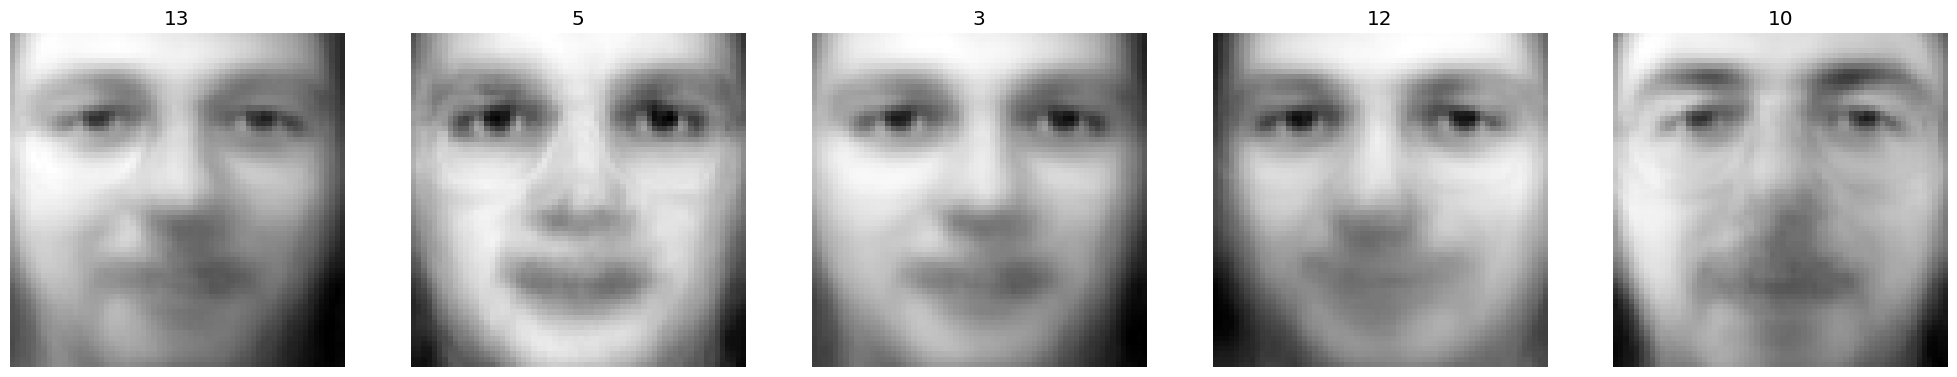

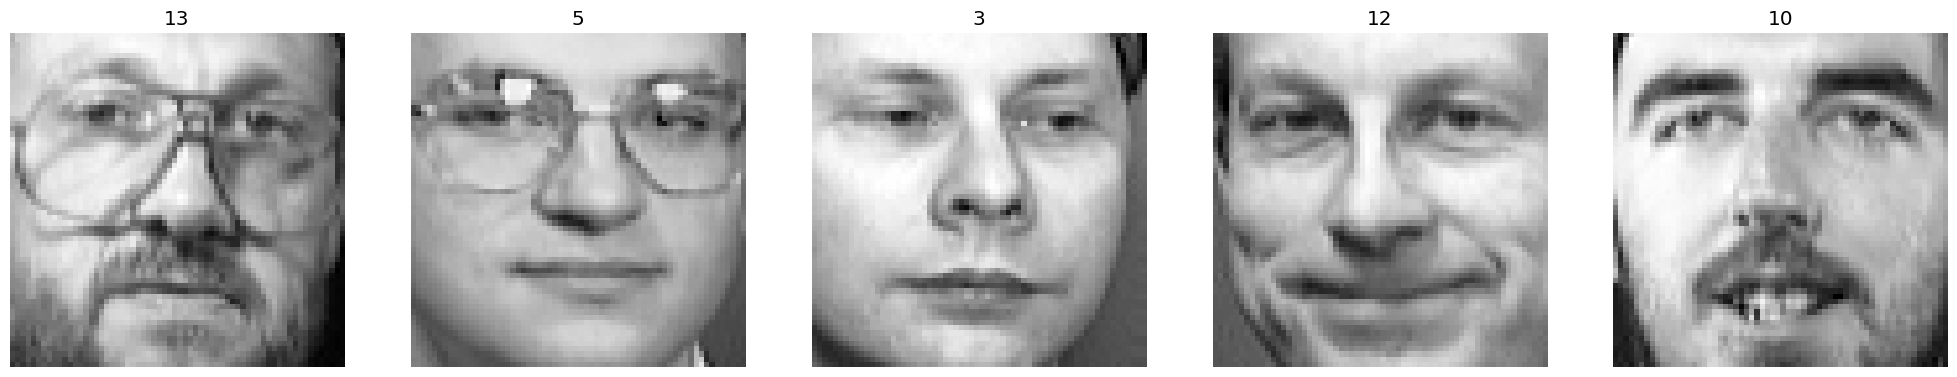

PCAs 10  Factor de compresion 0.24%


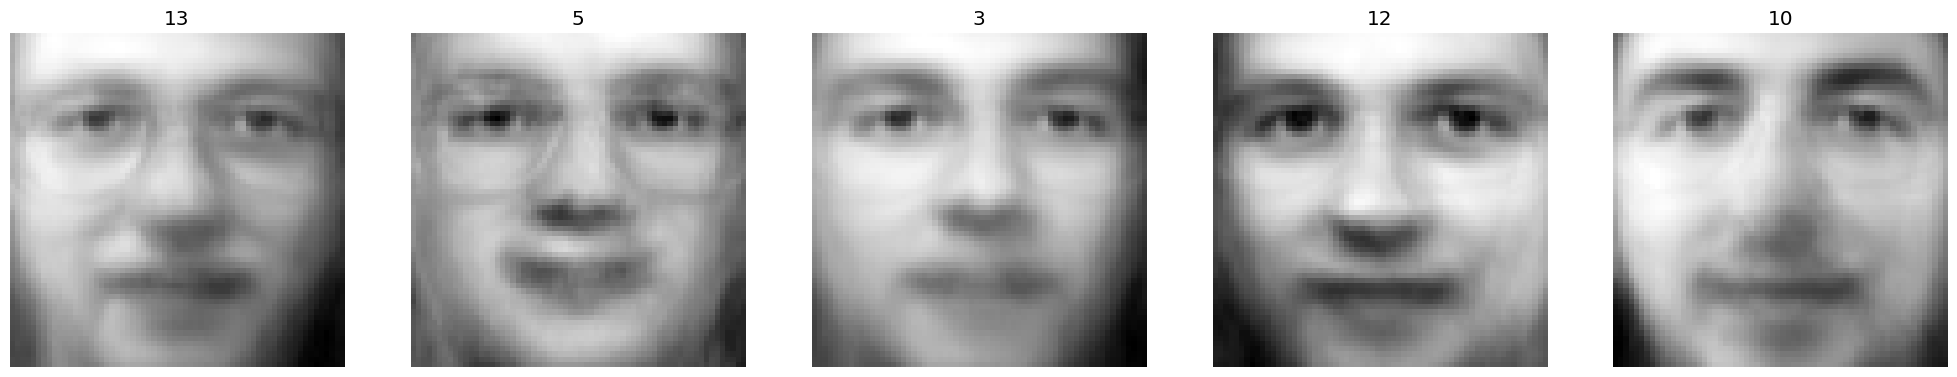

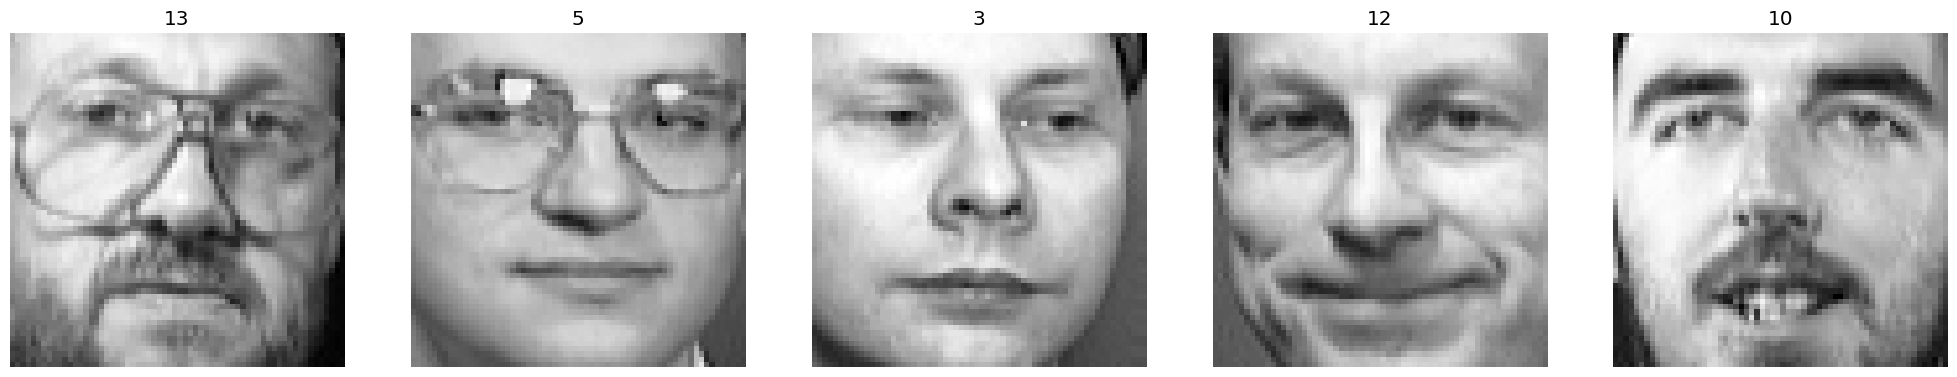

PCAs 16  Factor de compresion 0.39%


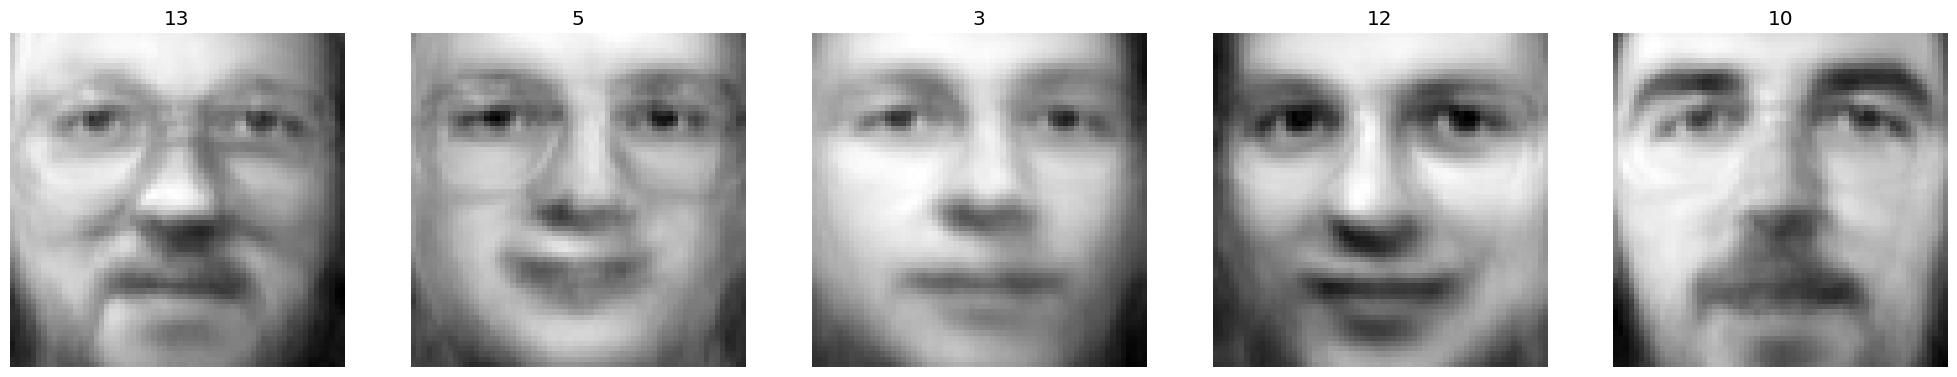

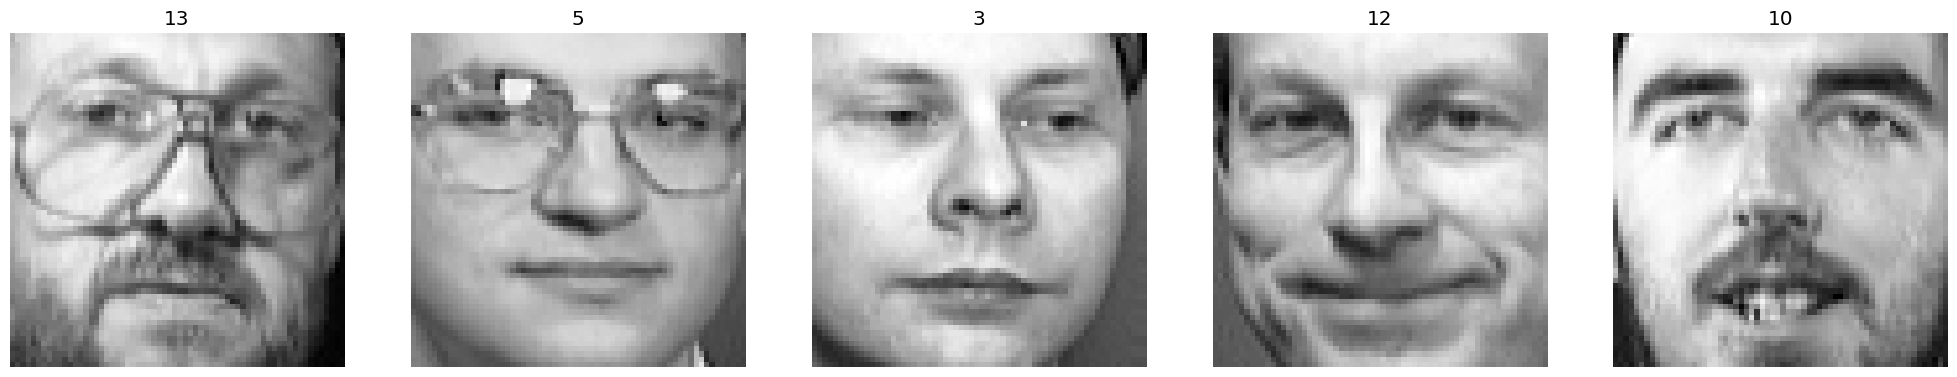

PCAs 22  Factor de compresion 0.54%


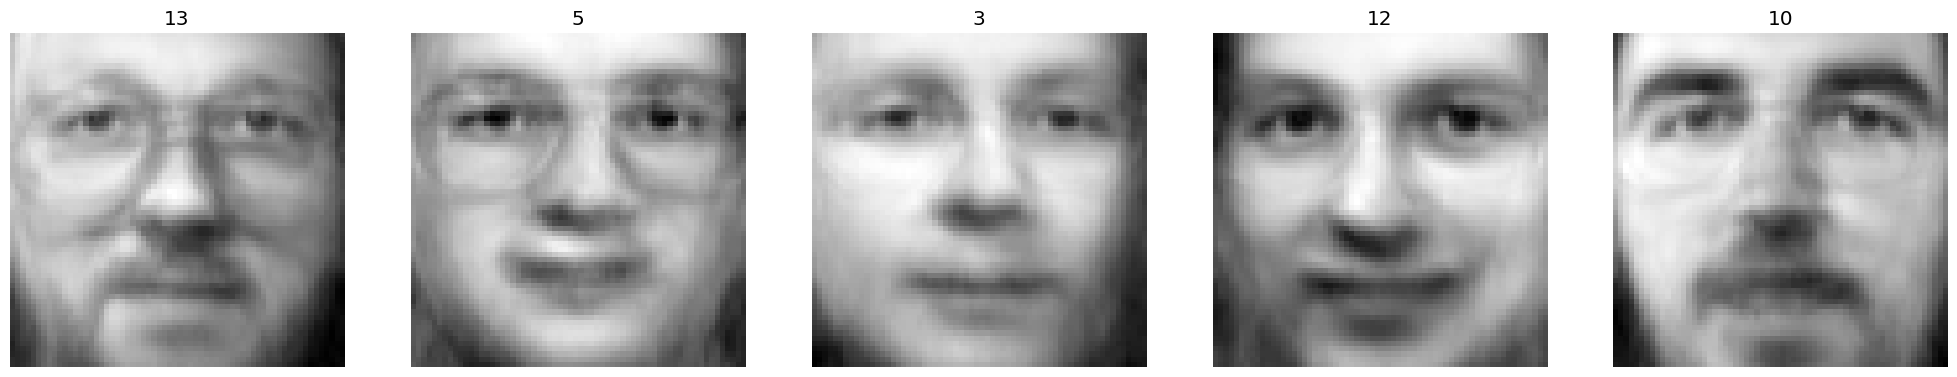

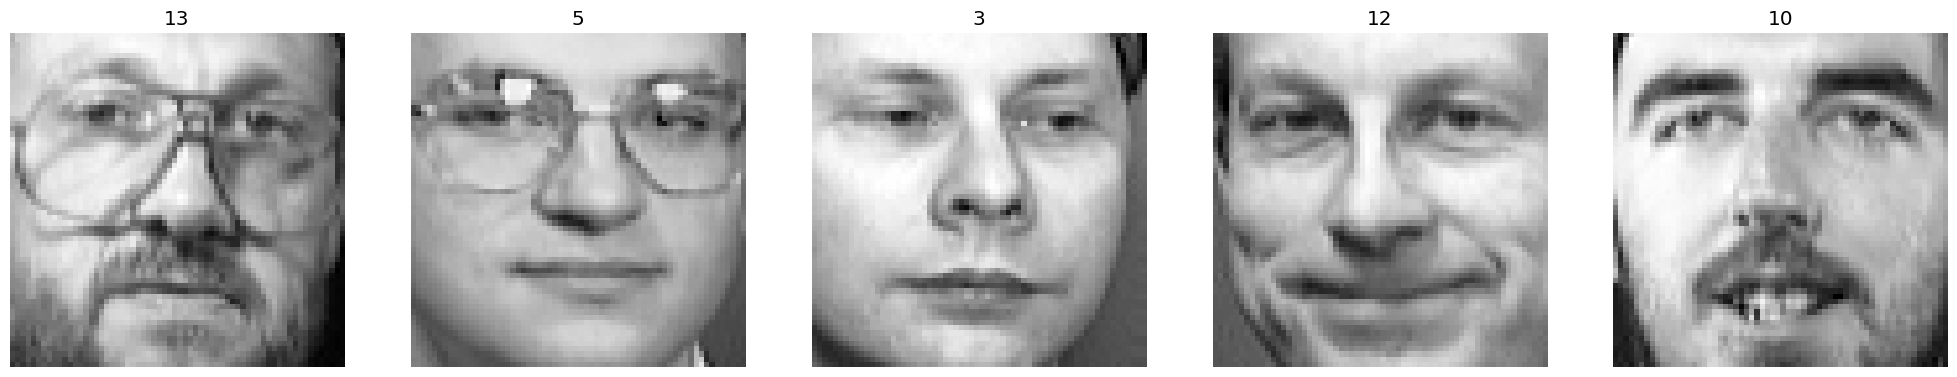

PCAs 28  Factor de compresion 0.68%


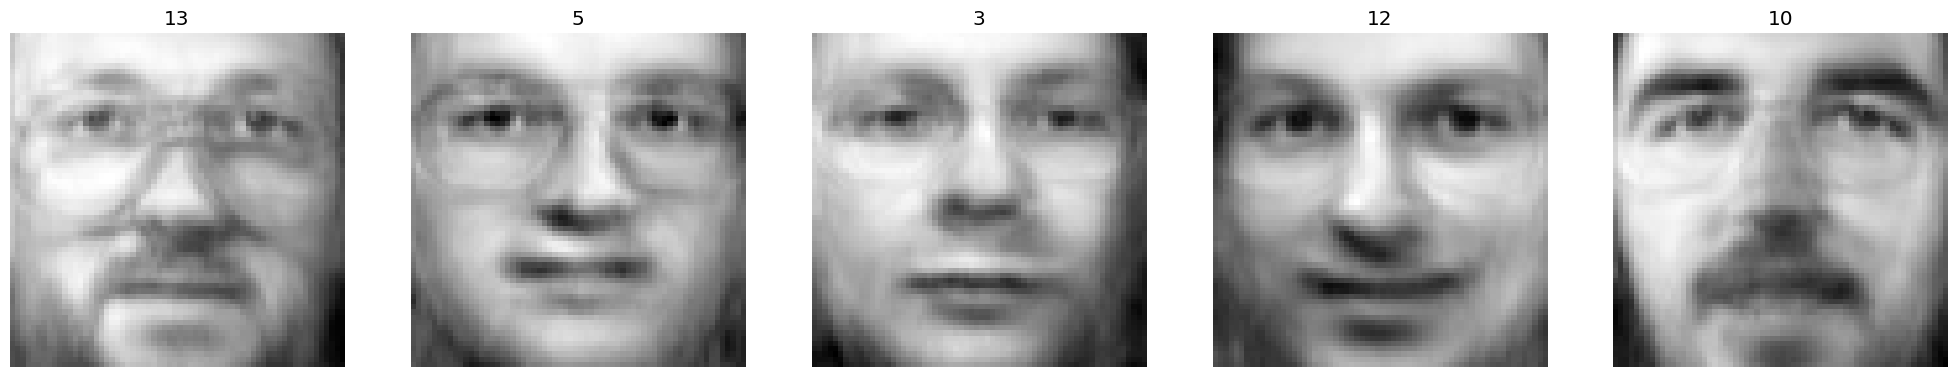

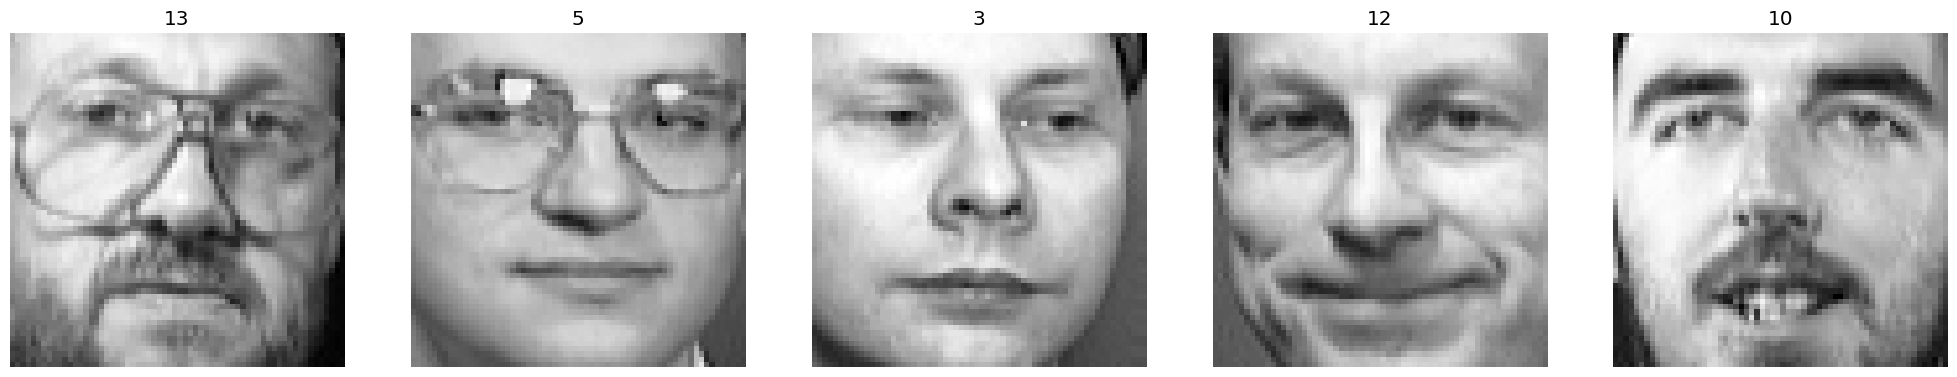

PCAs 34  Factor de compresion 0.83%


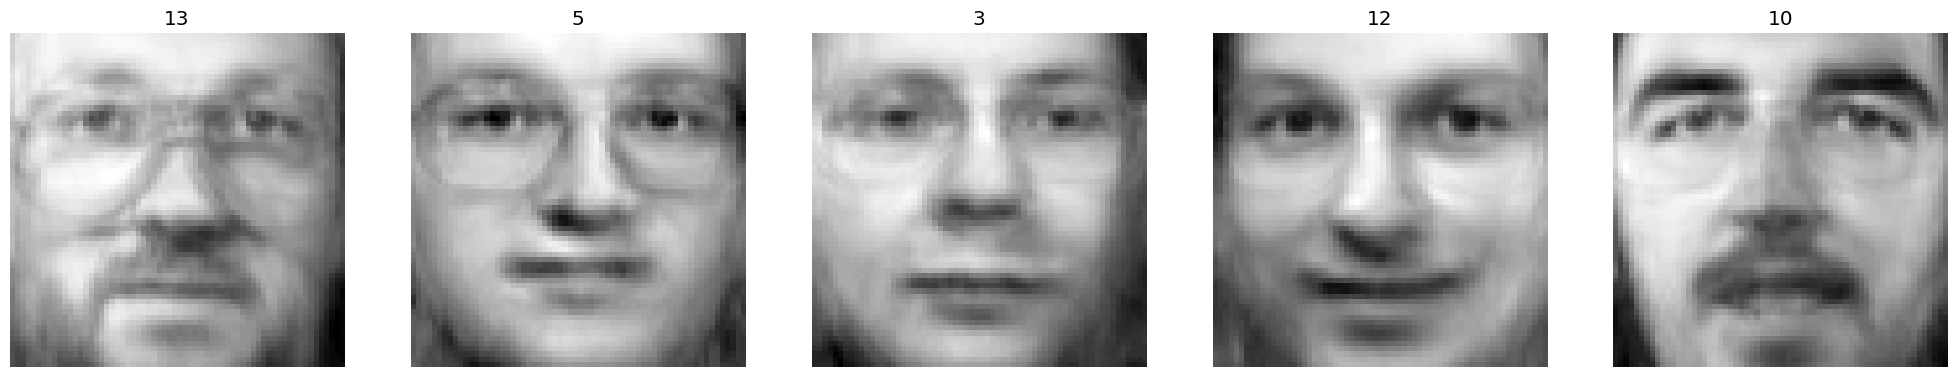

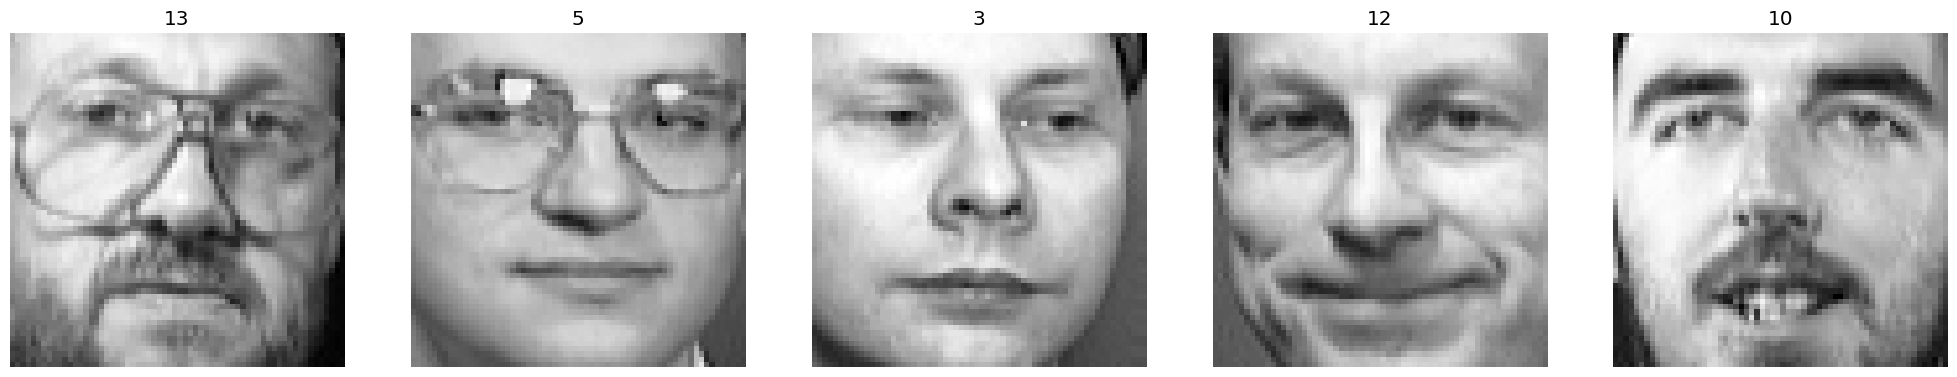

PCAs 40  Factor de compresion 0.98%


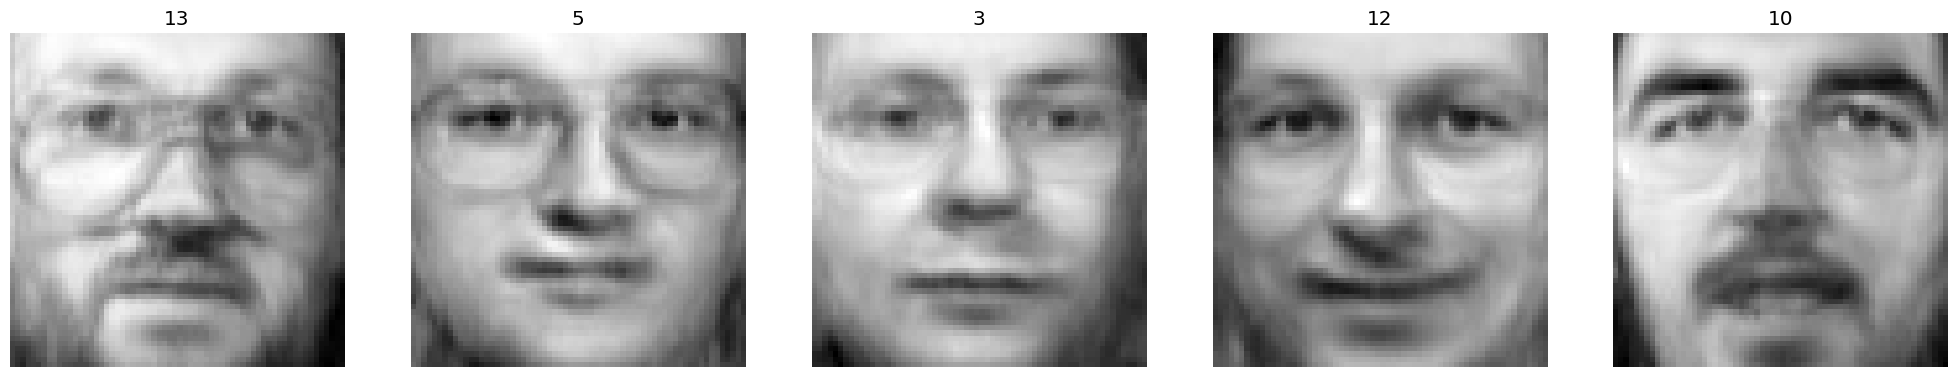

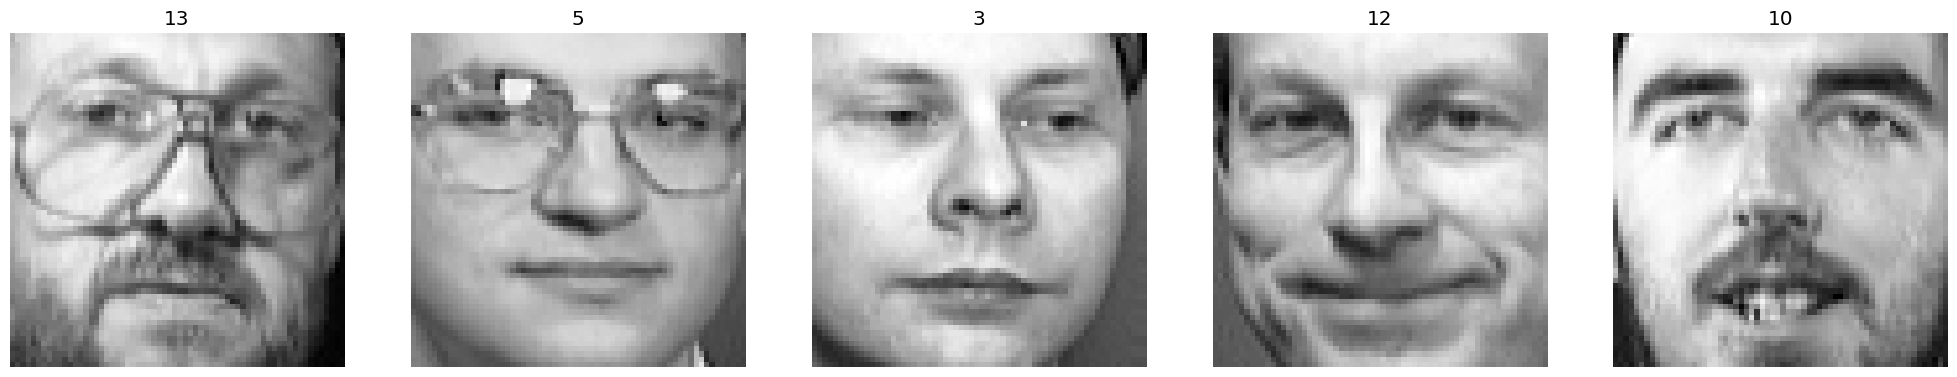

PCAs 150  Factor de compresion 3.66%


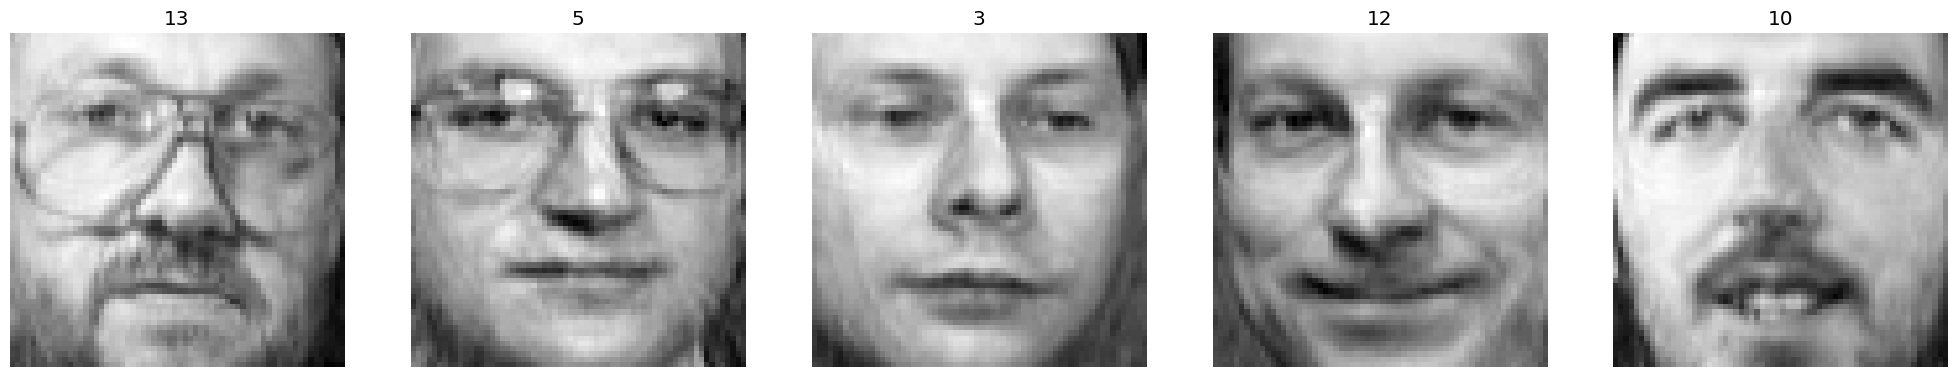

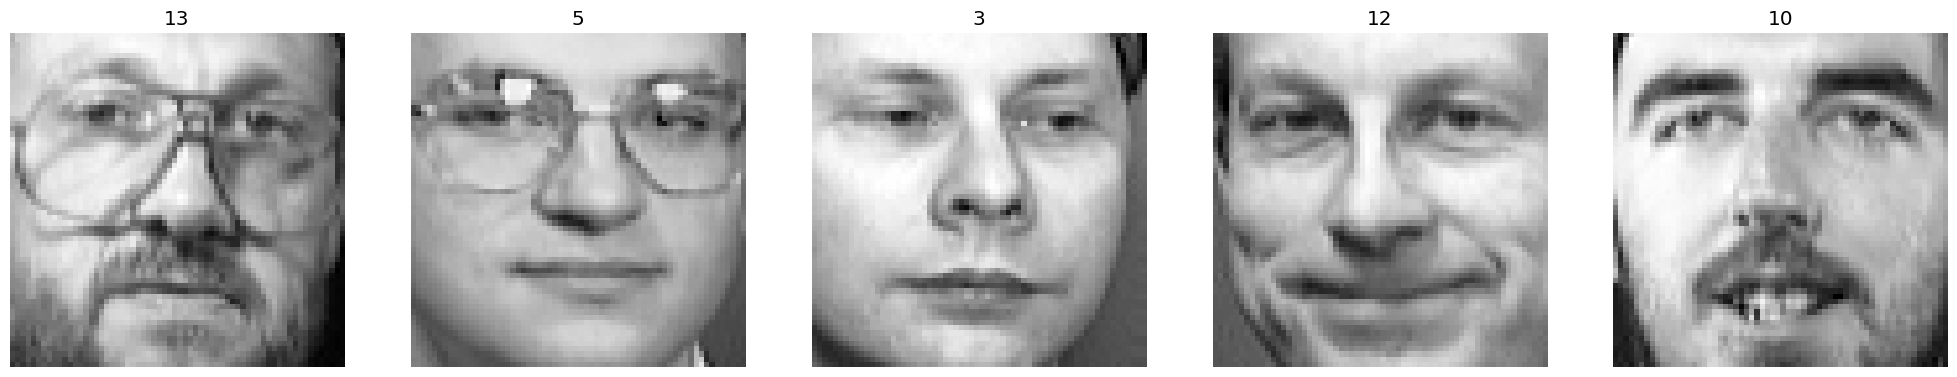

PCAs 300  Factor de compresion 7.32%


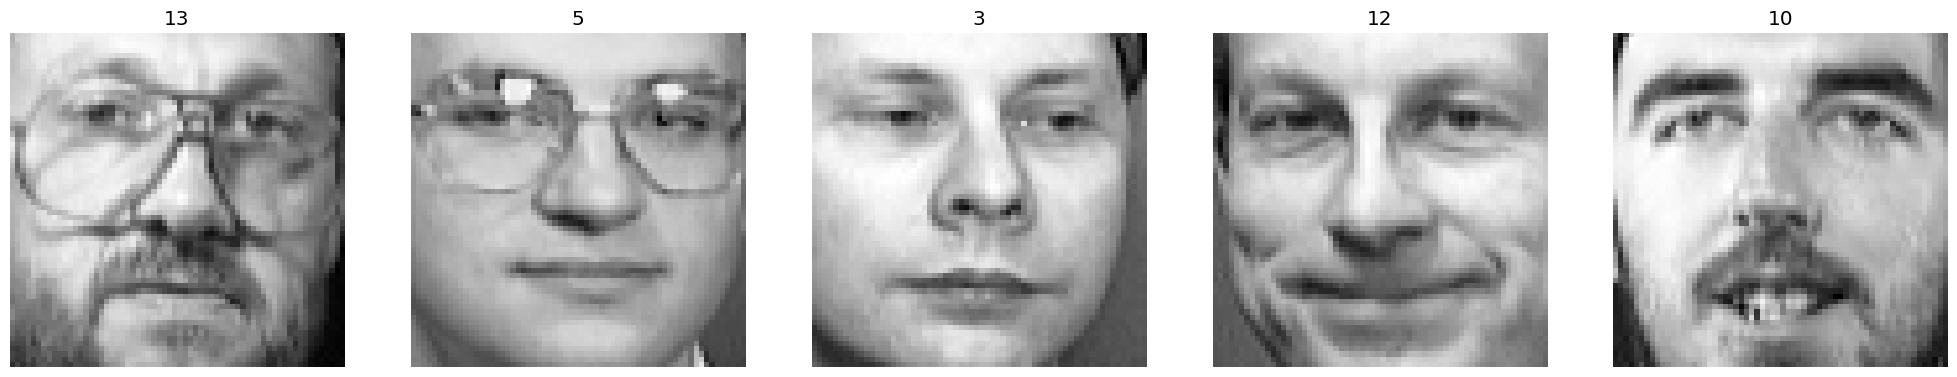

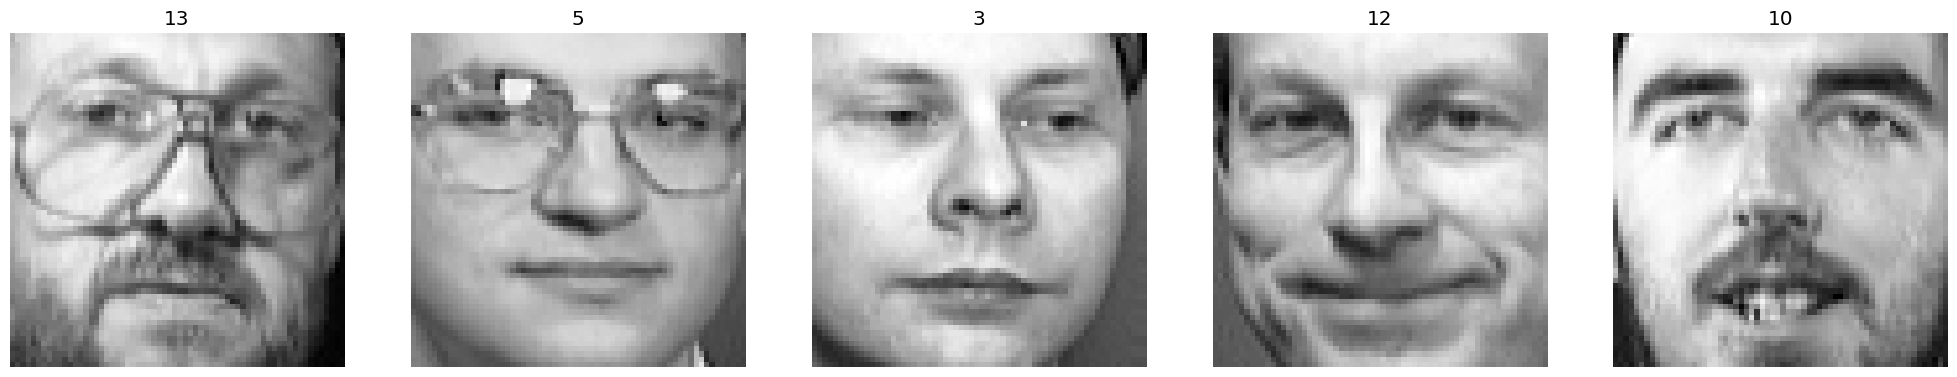

PCAs 320  Factor de compresion 7.81%


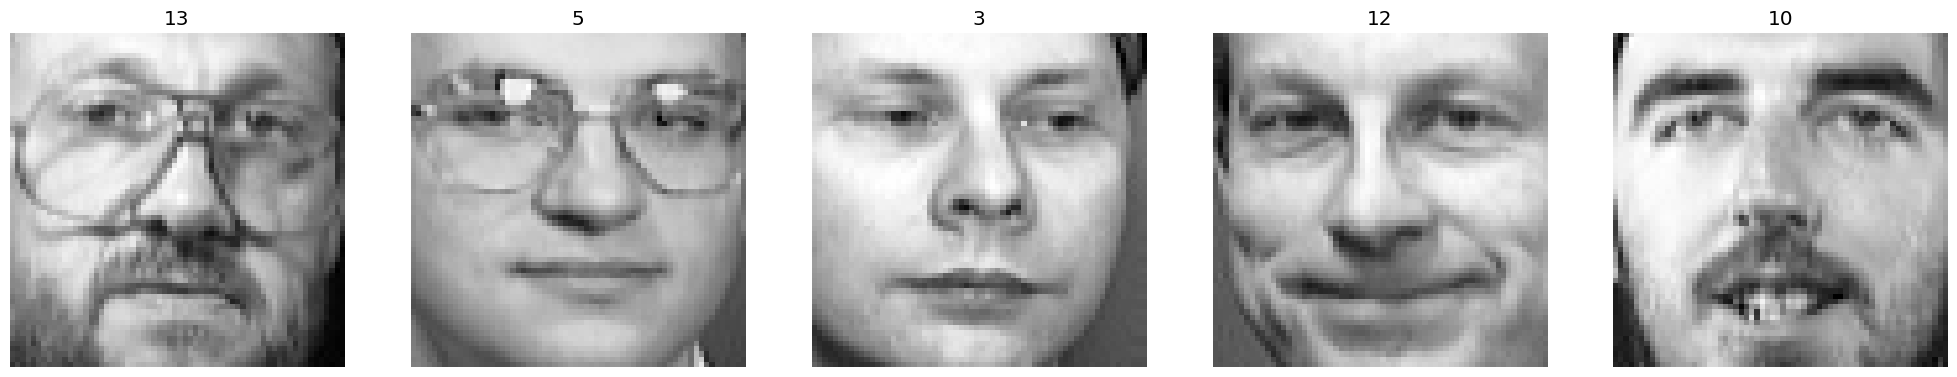

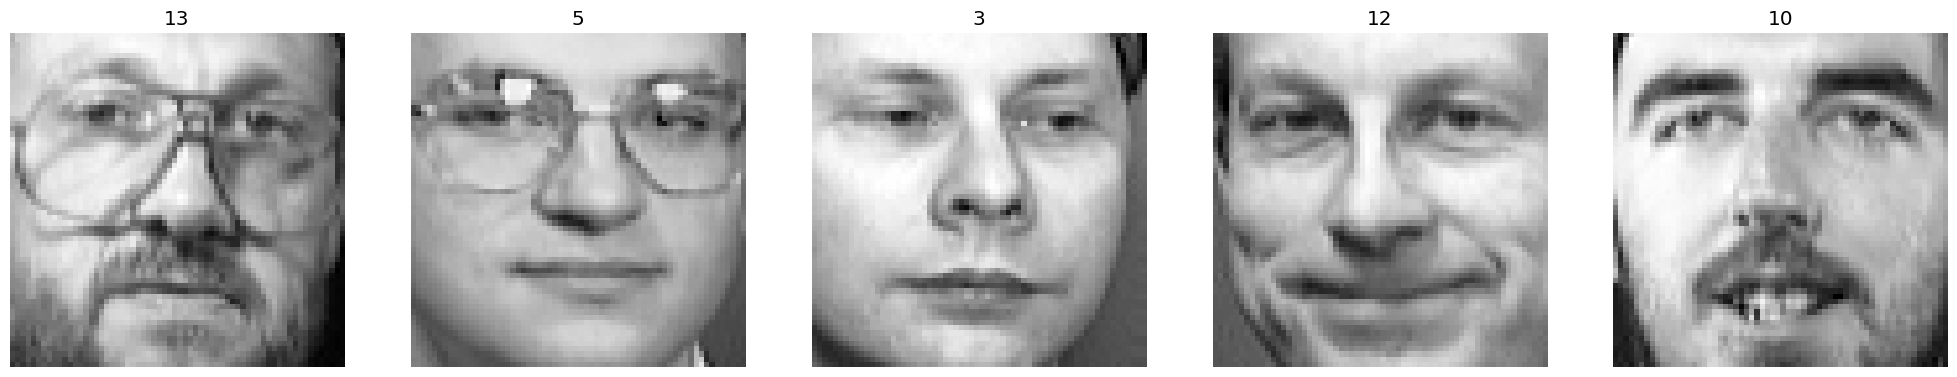

In [33]:
rango_7 = rango_5 + [150, 300, 320]
for i in rango_7:
    pca_rango = PCA(i)
    pca_rango_X_train = pca_rango.fit_transform(X_train)
        
    X_train_unzipped = pca_rango.inverse_transform(pca_rango_X_train)
    
    print(f"PCAs {i}  Factor de compresion {round(i/num_col_original*100,2)}%")
    plot_faces(X_train_unzipped[:5], y_train)
    plot_faces(X_train.values[:5], y_train)